In [4]:
from pyspeedy import Speedy
from datetime import datetime
from pyspeedy.callbacks import ModelCheckpoint, XarrayExporter

In [10]:
%%time
start_date = datetime(1980, 1, 1)  # Simulation start date (datetime object).
end_date = datetime(1980, 2, 29)  # Simulation end date.
spinup_date = datetime(1980, 2, 1)  # End of spinup period.

m = Speedy(
    start_date=start_date,
    end_date=end_date,
    #history_interval=36,
    #diag_interval=180,
    #output_vars=None
)

m.set_bc()

model_checkpoints = ModelCheckpoint(
    interval=36,  # Every how many time steps we will save the output file. 36 -> once per day.
    verbose=True,  # Print progress messages
    variables=None,  # Which variables to output. If none, save the most commonly used variables.
    spinup_date=spinup_date,  # End of spinup period
)

m.run(callbacks=[model_checkpoints])

CPU times: user 24.8 s, sys: 166 ms, total: 25 s
Wall time: 25.3 s


In [19]:
model_checkpoints.dataframe

<xarray.Dataset>
Dimensions:  (lon: 96, lat: 48, lev: 8, time: 29)
Coordinates:
  * lon      (lon) float32 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lat      (lat) float32 -87.22 -83.51 -79.79 -76.08 ... 79.79 83.51 87.22
  * lev      (lev) float32 0.95 0.835 0.685 0.51 0.34 0.2 0.095 0.025
  * time     (time) datetime64[ns] 1980-02-01 1980-02-02 ... 1980-02-29
Data variables:
    u        (time, lev, lat, lon) float32 -1.161 -0.8675 -0.572 ... 2.781 2.537
    v        (time, lev, lat, lon) float32 -3.48 -3.515 -3.519 ... -5.552 -5.649
    t        (time, lev, lat, lon) float32 247.6 247.2 246.9 ... 192.4 192.3
    q        (time, lev, lat, lon) float32 0.0003778 0.0003718 ... 0.0 0.0
    phi      (time, lev, lat, lon) float32 3.119e+03 3.176e+03 ... 2.304e+04
    ps       (time, lat, lon) float32 7.234e+04 7.178e+04 ... 1.023e+05

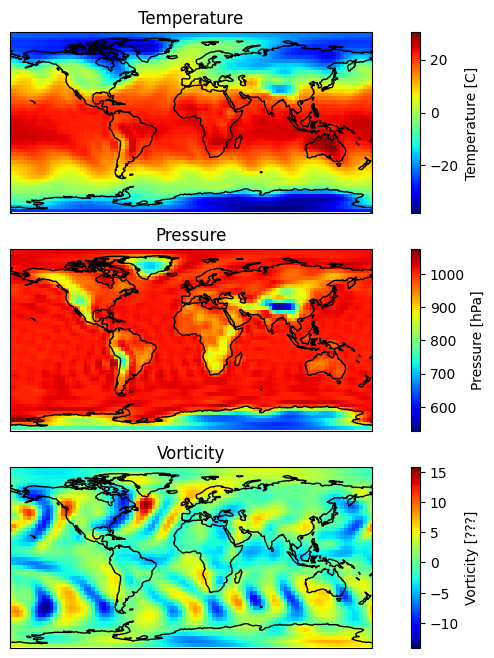

In [22]:
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from cartopy.feature import OCEAN
from cartopy.util import add_cyclic_point

# The shape of the t_grid field is ['lon', 'lat', 'lev']
# The vertical dimension is sorted in decreasing height.
# That means that the [:,:,0] indicates the highest level, while [:,:,-1] indicate the lowest level.
# For the temperature field we will plot the lowest level (surface).
# The shape of the ps_grid is ['lon', 'lat']

variables_to_plot = [
    # (model_variable_name, variable long name, units)
    (
        "t_grid",
        "Temperature",
        "[C]",
    ),  # Surface temperature in Kelvin degrees (in the grid space).
    ("ps_grid", "Pressure", "[hPa]"),  # Surface pressure,
    ("v_grid", "Vorticity", "[???]")
]

fig, axs = plt.subplots(
    3, 1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 8)
)

lon = m["lon"]
lat = m["lat"]

for i, (var, title, units) in enumerate(variables_to_plot):
    ax = axs[i]
    plt.sca(ax)

    ax.set_title(title)  # Add title for each subplot.
    ax.set_global()  # Set global extention
    ax.coastlines()  # Add coastlines
    ax.add_feature(OCEAN)  # Add oceans

    data_to_plot = m[var]
    if var == "t_grid":
        # data_to_plot has [lon, lat, lev] dimensions.
        data_to_plot = data_to_plot[:, :, -1]  # Keep the lowest level
        data_to_plot -= 273.15
    elif var == "ps_grid":
        data_to_plot /= 100
    elif var == "v_grid":
        data_to_plot = data_to_plot[:, :, -1]

    # Copy the longitude=0 degrees data to longitude=360 to have continuous plots
    data_to_plot, lon = add_cyclic_point(data_to_plot, coord=m["lon"], axis=0)
    lat = m["lat"]
    cs = ax.pcolormesh(
        lon,
        m["lat"],
        data_to_plot.T,
        transform=ccrs.PlateCarree(),
        cmap="jet",
        shading="auto",
    )
    cbar = plt.colorbar(cs, label=f"{title} {units}")
_ = plt.subplots_adjust(wspace=0.05)